# Importing Libraries

In [3]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import os
from os import path
from shutil import copy
import keras
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img
from tensorflow.keras.layers import (Conv2D, BatchNormalization, Activation, MaxPooling2D, GlobalAveragePooling2D, 
                          Dense, Flatten, Dropout)
from tensorflow.keras.optimizers import RMSprop, Adam, SGD
from tensorflow.keras import regularizers
from tensorflow.keras.callbacks import CSVLogger, ModelCheckpoint, ReduceLROnPlateau
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split

ModuleNotFoundError: No module named 'tensorflow'

# Importing Dataset and Plotting Images

<function matplotlib.pyplot.show(close=None, block=None)>

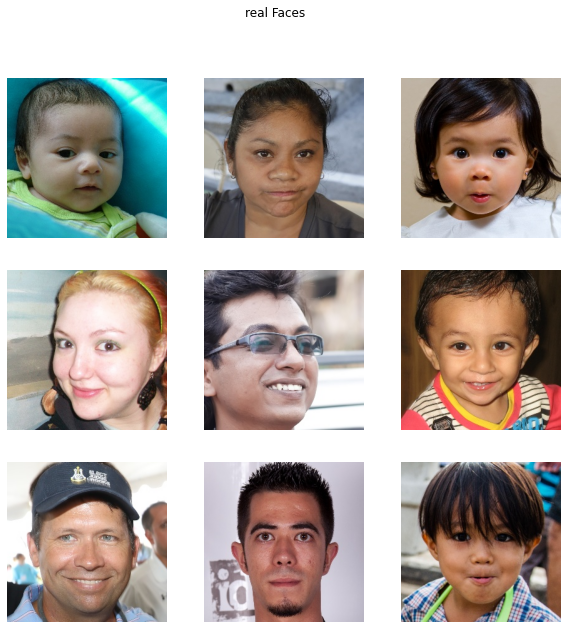

In [2]:
path = "C:/Soheb Project/IMAGE PROCESSING/real_vs_fake/real-vs-fake"


def plot_img(path, set_):
    dir_ = os.path.join(path, 'train', set_)
    k = 0
    fig, ax = plt.subplots(3,3, figsize=(10,10))
    fig.suptitle(set_ + 'Faces')
    for j in range(3):
        for i in range(3):  
            img = load_img(os.path.join(dir_, os.listdir(os.path.join(dir_))[k]))      
            ax[j,i].imshow(img)
            ax[j,i].set_title("")
            ax[j,i].axis('off')
            k +=1
  
    plt.suptitle(set_ + ' Faces')
    return plt

plot_img(path, 'real').show

### Fake Set

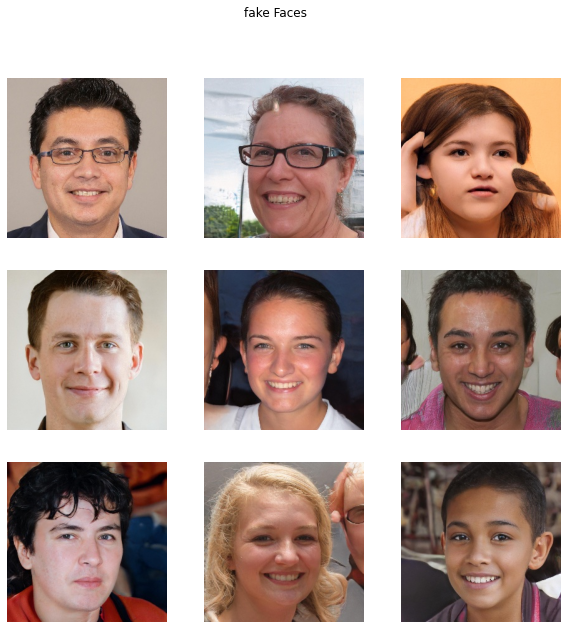

In [3]:
plot_img(path, 'fake').show()

# Train and Validation Set 

In [4]:
bs = 64
row, col = 224, 224
train_datagen = ImageDataGenerator(rescale=1./255,
                                   horizontal_flip=True
                                  )
training_set = train_datagen.flow_from_directory(path + '/train',
                                                 class_mode='binary',
                                                 shuffle=True,
                                                 target_size=(row,col),
                                                 batch_size=bs
                                                )
val_test_datagen = ImageDataGenerator(rescale=1./255)

validation_set = val_test_datagen.flow_from_directory(path + '/valid',
                                                      class_mode='binary',
                                                      shuffle=True,
                                                      target_size=(row,col),
                                                      batch_size=bs
                                                     ) 
test_set = val_test_datagen.flow_from_directory(path + '/test',
                                                class_mode='binary',
                                                shuffle=True,
                                                target_size=(row,col),
                                                batch_size=bs
                                               )
training_set.class_indices

Found 484 images belonging to 2 classes.
Found 20000 images belonging to 2 classes.
Found 20000 images belonging to 2 classes.


{'fake': 0, 'real': 1}

# Creating Model
I tried Different model architecture like VGG, mobilenet but DenseNet works best
following chunk code itself illustrates gan code flow:

In [5]:
from tensorflow.keras.applications import DenseNet121
def get_model():
    densenet = DenseNet121(weights='imagenet',
                           include_top=False,
                           input_shape=(128,128,3)
                          )
    model = tf.keras.models.Sequential([densenet,
                                        GlobalAveragePooling2D(),
                                        Dense(512, activation='relu'),
                                        BatchNormalization(),
                                        Dropout(0.3),
                                        Dense(1, activation='sigmoid')
                                      ])
    model.compile(optimizer=Adam(lr=0.001),
                loss='binary_crossentropy',
                metrics=['accuracy']
                )

    return model

spoofnet = get_model()
spoofnet.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
densenet121 (Functional)     (None, 4, 4, 1024)        7037504   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1024)              0         
_________________________________________________________________
dense (Dense)                (None, 512)               524800    
_________________________________________________________________
batch_normalization (BatchNo (None, 512)               2048      
_________________________________________________________________
dropout (Dropout)            (None, 512)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 513       
Total params: 7,564,865
Trainable params: 7,480,193
Non-trainable params: 84,672
_________________________________________

C:\Users\anuja\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\optimizer_v2\optimizer_v2.py:355: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


In [6]:
#Notice the dropout in parameters

#To avoid the problem of overfitting, avoid training the entire network. layer.trainable=False will freeze all the layers, keeping only the last eight layers (FC) to detect edges and blobs in the image. Once the model is fitted well, it can be fine-tuned by using layer.trainable=True.

### Defining Model Checkpoints

In [7]:
checkpoint = ModelCheckpoint(filepath='spoffnet.h5',
                             save_best_only=True,
                             verbose=1,
                             mode='min',
                             moniter='val_loss'
                            )
reduce_lr = ReduceLROnPlateau(monitor='val_loss', 
                              factor=0.2, 
                              patience=3, 
                              verbose=1, 
                              min_delta=0.0001
                             )
csv_logger = CSVLogger('training.log')

callbacks = [checkpoint, reduce_lr, csv_logger]

# Training Model

In [8]:
steps_per_epoch = training_set.n // training_set.batch_size
validation_steps = validation_set.n // validation_set.batch_size
#steps_per_epoch = 4
#validation_steps = 4

hist = spoofnet.fit(training_set,
                    validation_data=validation_set,
                    callbacks=callbacks,
                    steps_per_epoch=steps_per_epoch,
                    validation_steps=validation_steps,
                    epochs=4
                   )

Epoch 1/4
7/7 [==============================] - 2874s 472s/step - loss: 0.8375 - accuracy: 0.6286 - val_loss: 2.4408 - val_accuracy: 0.5002

Epoch 00001: val_loss improved from inf to 2.44082, saving model to spoffnet.h5
Epoch 2/4
7/7 [==============================] - 2737s 450s/step - loss: 0.4895 - accuracy: 0.7810 - val_loss: 2.3325 - val_accuracy: 0.5001

Epoch 00002: val_loss improved from 2.44082 to 2.33249, saving model to spoffnet.h5
Epoch 3/4
7/7 [==============================] - 7124s 1182s/step - loss: 0.3393 - accuracy: 0.8571 - val_loss: 3.6154 - val_accuracy: 0.5008

Epoch 00003: val_loss did not improve from 2.33249
Epoch 4/4
7/7 [==============================] - 3015s 495s/step - loss: 0.2897 - accuracy: 0.8976 - val_loss: 3.0948 - val_accuracy: 0.5011

Epoch 00004: val_loss did not improve from 2.33249


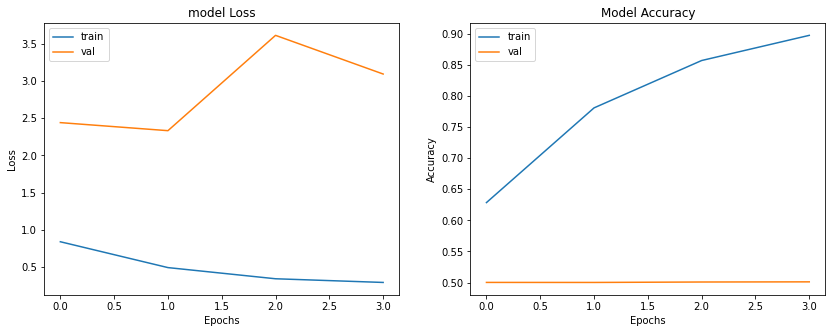

In [9]:
plt.figure(figsize=(14,5))
plt.subplot(1,2,2)
plt.plot(hist.history['accuracy'])
#plt.plot(hist['accuracy'])
plt.plot(hist.history['val_accuracy'])
#plt.plot(hist['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(['train', 'val'])
plt.subplot(1,2,1)
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['train', 'val'])
plt.show()

# Accuracy On test set

In [10]:
_, accu = spoofnet.evaluate(test_set)
print('Final Test Acccuracy = {:.3f}'.format(accu*100))

313/313 [==============================] - 2612s 8s/step - loss: 3.0666 - accuracy: 0.5007
Final Test Acccuracy = 50.070


# Confusion Matrix and Classification Report

Confusion Matrix
[[9976   24]
 [9972   28]]
Classification Report
              precision    recall  f1-score   support

        fake       0.50      1.00      0.67     10000
        real       0.54      0.00      0.01     10000

    accuracy                           0.50     20000
   macro avg       0.52      0.50      0.34     20000
weighted avg       0.52      0.50      0.34     20000



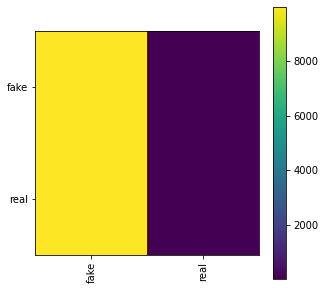

In [11]:
y_pred = spoofnet.predict(test_set)
y_pred = (y_pred < 0.5).astype(np.int)

from sklearn.metrics import confusion_matrix, classification_report
cm = confusion_matrix(test_set.classes, y_pred)
print('Confusion Matrix')
print(cm)

names = ['fake', 'real']
print('Classification Report')
print(classification_report(test_set.classes, y_pred, target_names=names))

plt.figure(figsize=(5,5))
plt.imshow(cm)
plt.colorbar()
tick_mark = np.arange(len(names))
_ = plt.xticks(tick_mark, names, rotation=90)
_ = plt.yticks(tick_mark, names)

Text(0.5, 145.31999999999996, 'Predicted')

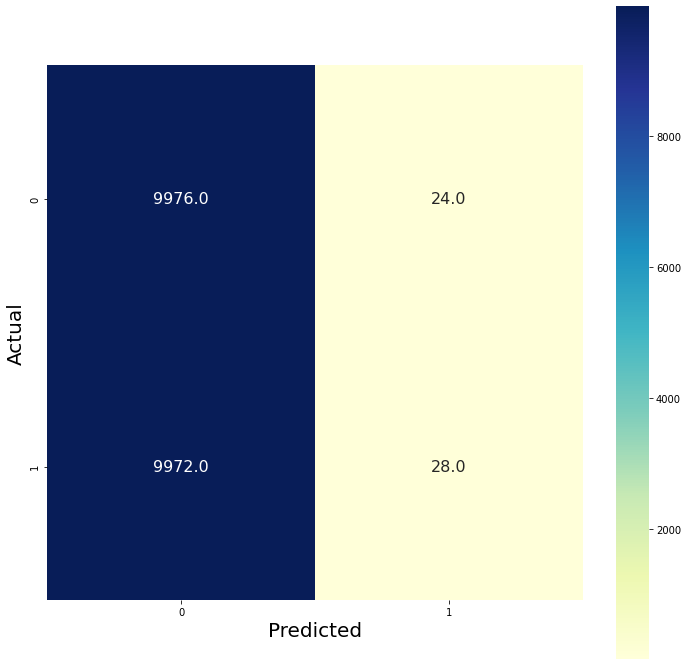

In [32]:
from matplotlib import pylab as pl
import numpy as np
import seaborn as sns
plt.figure(figsize=(12, 12))
ax = sns.heatmap(cm, cmap="YlGnBu", fmt=".01f",annot_kws={'size':16}, annot=True, square=True)
ax.set_ylabel('Actual', fontsize=20)
ax.set_xlabel('Predicted', fontsize=20)
